In [1]:
import io
import os
import cv2
import keras_ocr
import pytesseract
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from enum import Enum
from pytesseract import Output
from google.cloud import vision
from PIL import Image, ImageDraw

# Project. 영수증 데이터 추출 서비스

# 1. 프로젝트 개요

> 우리가 물건을 구매하면 판매자는 돈을 받았음을 증명하는 영수증을 구매자에게 지급한다.<br>
> 개인 또는 기업은 받은 영수증을 활용하여 국세청에 소득공제 및 사업소득에 사용하거나, 고자본인 경우 자금의 사용 출처를 밝히는데 사용한다. 이에, 영수증의 내용을 OCR 기법으로 추출하는 서비스를 진행하고자 한다.<br>

> [시나리오]<br>
> 가상의 인물 '철수'는 소득 공제를 받기 위해 영수증의 내용을 컴퓨터에 저장하려한다.<br>
> 1년치 영수증을 모두 손수 타이핑하기에는 너무 많은 시간이 걸려 OCR 기법을 활용하여 자동으로 영수증의 정보를 추출하고자 한다.

# 2. OCR 모델 실험

> '철수'는 OCR 기법을 사용하기 위해 인터넷에 OCR을 검색해보니, 여러 Keras, Tesseract 등 여러 OCR 모델이 있음을 확인했다.<br>
> '철수는' 어떤 모델이 가장 좋을지 고민하며, 검색해본 OCR 모델을 직접 사용하여 실험 후 적합한 모델을 선택하기로 했다.

## 2.1 Keras OCR

### 2.1.1 load Keras OCR 

> 실험환경에서 Keras OCR의 설치여부를 확인하고, OCR을 위한 파이프라인을 생성한다.

In [2]:
!pip list | grep keras-ocr

keras-ocr                     0.8.6
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


### 2.1.2 Use Keras OCR 

> 이미지가 저장되어있는 url 목록을 list로 구성 후, keras OCR의 recognize()으로 문자를 인식 및 검출하는 과정을 진행한다.

In [4]:
image_urls = ['https://live.staticflickr.com/634/22881678545_14c108954c_b.jpg',
              'https://www.needreceipt.com//storage/images/cafeDefault.png'
             ]

images = [keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

### 2.1.3 Visualizing images

>  keras OCR가 검출한 텍스트 데이터를 시각화하여 확인하는 과정을 진행한다.

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


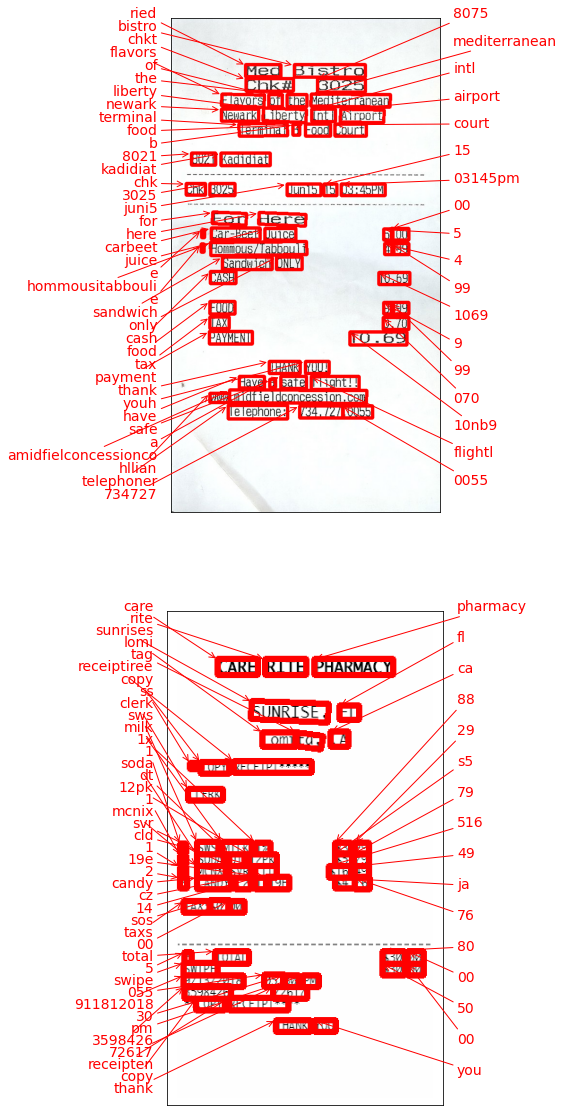

In [5]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0], ax=ax)

> 영수증에 있는 모든 정보를 인식하고 문자를 검출하여 출력한 결과를 확인할 수 있다.<br>
> 그러나 모든 정보를 올바르게 검출하지 못한 결과도 확인할 수 있다.<br>
> 영수증의 가게 이름인 'med'를 'ried'로 검출한 모습을 확인할 수 있다.<br>
> 또한, 문장에 특수기호가 있을 시, 원문과 다른 단어로 결과를 출력하는 모습을 확인할 수 있다.

## 2.2 tesseract OCR

> OCR 오픈소스 라이브러리인 테서랙트를 활용하여 영수증의 내용을 검출하는 실험을 진행한다.<br>
> 이를 위해, 테서랙트로 문자 검출하고 이미지 자르는 사용자 정의 함수를 구현한다.

### 2.2.1 install tesseract OCR

In [6]:
!pip install pytesseract

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### 2.2.2 Custom function for text detection and output

> 문자 검출하고 이미지 분리하며, 검출한 문자 목록을 반환하는 기능을 위한, 사용자 정의 함수를 구현한다.

In [7]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    
    word = []
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',
            config=custom_oem_psm_config,
            output_type=Output.DICT)
        word.append(recognized_data['text'].replace("\n\x0c", ""))
        #print(recognized_data['text'])
        
    return word

### 2.2.3 use tesseract OCR

In [8]:
image_path =['./ex_Data/ex18/1.jpg', './ex_Data/ex18/2.jpg' ]

for image in image_path:
    cropped_image_path_list = crop_word_regions(image)
    recognize_images(cropped_image_path_list)
    sentence = recognize_images(cropped_image_path_list)
    print(sentence)

['Mort', 'rRIstro', '(*ijyb< tt', 'tf) 7}', 'Fiavors', 'OT', 'the', 'Mediterranean', 'Newark', '| iperty', 'Tot |', 'Airoort', 'Termina |', ',', 'Food', 'Court', 'S()7 |', 'Kadidiat', 'Chk', '3075', 'Juni5 15', '3:45PM', '— Or', 'rere', '|', 'ar-Beet', 'Juice', 'y OD)', '|', 'Hommous/ Tabbou |', '1', '4 QQ', 'Sanawicn', 'ONLY', 'ASH', '10.69', 'FOOD', '4 OY', 'TAX', '0. #0', 'PAYMEN |', '10.69', 'THANK', 'YOU!', 'r', 'Have', 'd', 'Sate', 'flight! !', 'NA LA', 'midfieldconcession.com', 'Telepnone:', '£34. 7/7 O55']
['(CARE', 'Ri Te', 'PHARMAC Y', 'SUNRISE,', '|', 'Lomita,', '( A', 'were y', 'xP Pr iP) eee', 'eR', 'L', 'SWS', 'MILK', 'LA', '$3.29', 'L', 'SUDA', 'yy', 'Lee', '45.79', 'L', 'VIC NX', 'SVR', '(} i)', '$16.49', '/', 'T ANY', '( /', '|. |SrF', '$4.76', 'TAX: $0.00', 'ee ee ee', '>', 'TOTAL', '$30.00', 'SWieE', '$30.00', '4/13//7Y1%', '5": 30)', '~ Ny)', '3949R4/6', '(fol/é', 'were y', 'nel Pe Ye tre', 'TRANK', 'YOU']


> 영수증에 있는 모든 정보를 인식하여 출력한 결과를 확인할 수 있다.<br>
> 그러나 모든 정보를 올바르게 '검출'하는데는 낮은 성능 결과를 확인할 수 있다.<br>
> 원문의 정보와 다른 단어로 출력하거나, 특수기호 또는 .<br>
> 또한, 문장에 특수기호가 있을 시, 원문과 다른 단어로 결과를 출력하는 모습을 확인할 수 있다.

# 3. 모델 평가 조건

> 거래한 물건을 교환, 반품하거나 국세청에 소득공제를 신청하기 위해서는 필수로 제시해야하는 정보가 있다.<br>
> 1. 거래한 대상을 특정할 수 있는 단어<br>
> 2. 거래한 날짜<br>
> 3. 거래한 물품 내역<br>
> 4. 거래 대금<br>
> <br>
> 위 4가지 조건이 충족되지 않으면, 실제로 거래가 이루어졌음을 입증하는데 문제가 발생한다.<br>
> 이에, 위 4가지 조건을 얼마나 잘 검출하는지의 여부를 좋은 모델의 기준으로 활용하여 모델을 평가한다.<br>
> <br>
> PS. 영수증의 주소 정보는 거래 사실 입증 시,거래한 대상이 중복되었을 때 보조지표로 사용된다.<br>
> 그러나, 주요 지표로 사용하지는 않으므로, 모델 평가에 있어 조건 항목에 포함하지 않는다.

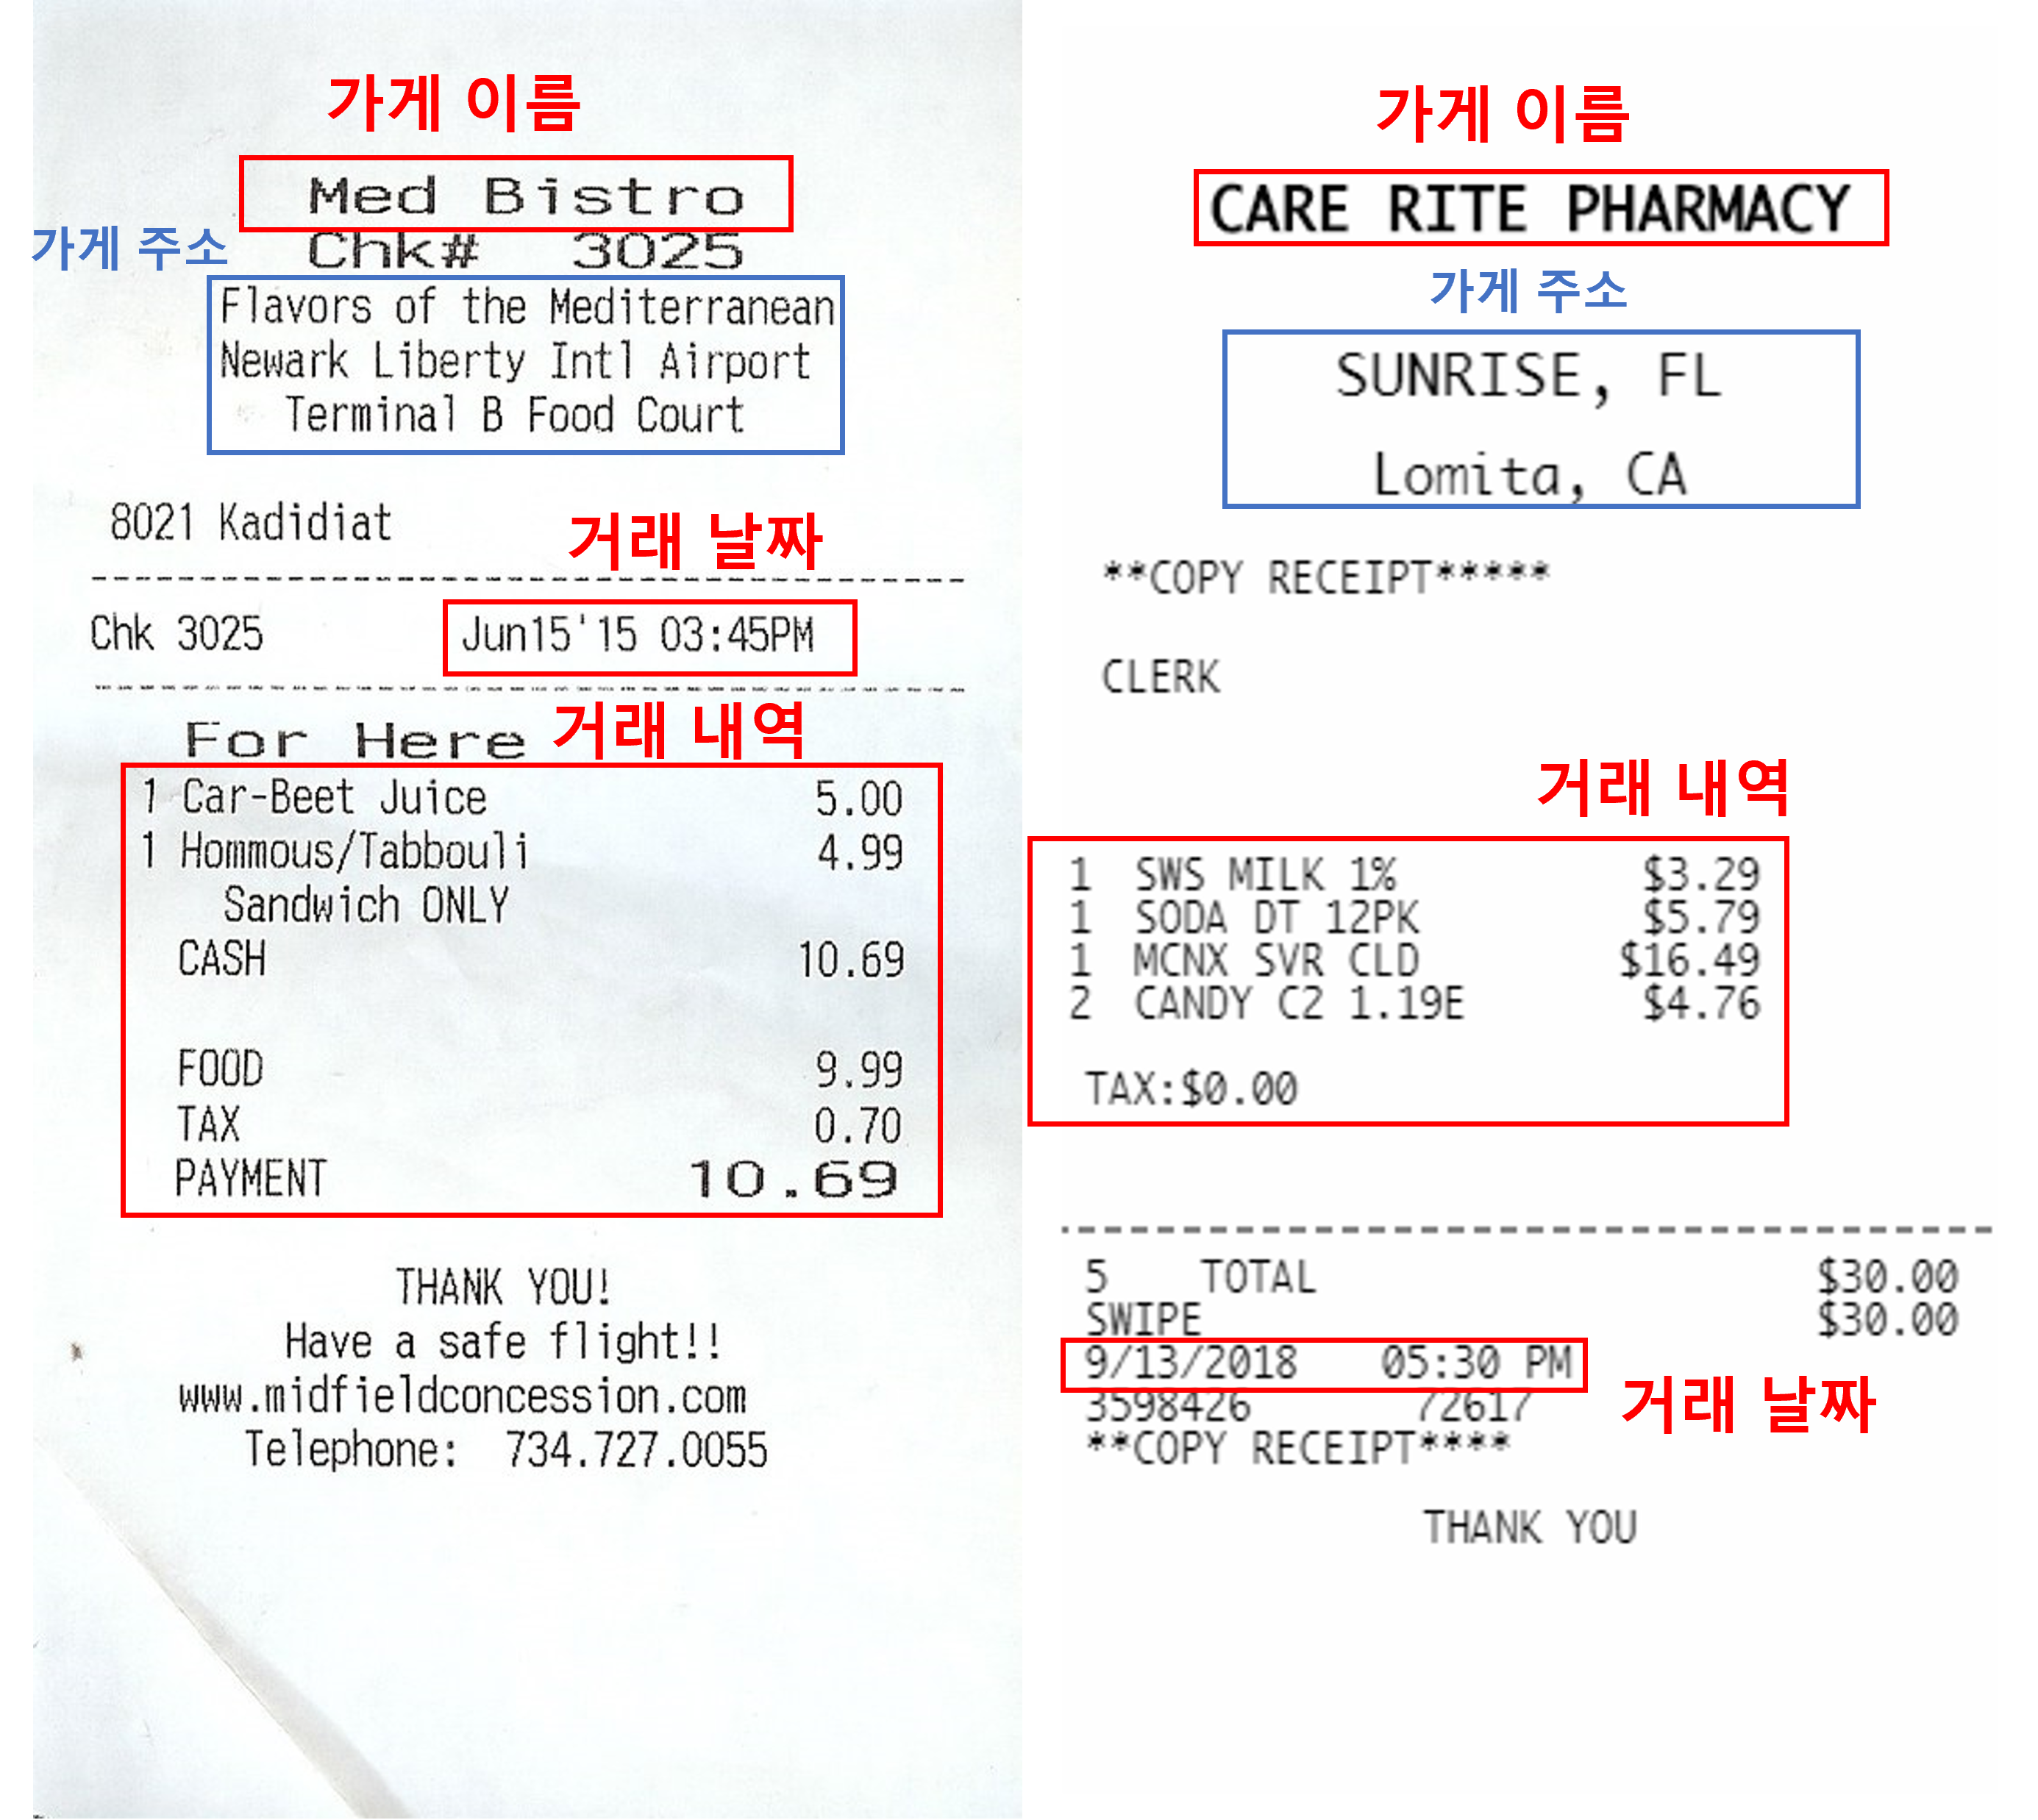

# 4. 모델 평가

## 4.1 Keras OCR 결과 분석

> [가게 이름]<br>
> 원본 : Med Bistro<br>
> keras OCR 모델 : ried bistro<br>
<br>
> 'Med'를 'ried'라는 다른 단어로 표현한 모습을 볼 수 있다.<br>
<br> --------------------------------------------------------
<br><br>
> 원본 : CARE RITE PHARMACY<br>
> keras OCR 모델 : care rite pharmacy<br>
<br>
> 원본 정보와 동일한 텍스트 데이터를 인식 및 검출하는 모습을 확인할 수 있다.

> [거래 날짜]<br>
> 원본 : Jun15' 15 03:45 PM<br>
> keras OCR 모델 : juni5 15 03145 pm<br>
<br>
> 숫자 1을 영문 i로 출력한 모습과, 시간 표현을 위한 특수기호 ':'를 숫자 1로 표현하는 모습을 볼 수 있다.<br>
<br> --------------------------------------------------------
<br><br>
> 원본 : 9/13/2018  05:30 PM<br>
> keras OCR 모델 : 911812018 055 30 pm<br>
<br>
> 특수 문자 '/'을 숫자 '1'로 출력한 모습과, 시간 표현을 위한 특수기호 ':'를 숫자 5로 표현하는 모습을 볼 수 있다.<br>

> [거래 내역]<br>
> 원본 : 1 Car-Beet Juice<br>
> keras OCR 모델 : e carbeet<br>
<br>
> 원본 : 1 Hommous/Tabbouli<br>
> keras OCR 모델 : e hommoustabbouli<br>
<br>
> 원본 : Sandwich ONLY<br>
> keras OCR 모델 : sandwich only<br>
<br>
> 숫자 1을 영문 e로 출력한 모습과, 특수기호 '-'과 'Hommous/Tabbouli'의 특수기호 '/'를 생략하는 모습을 볼 수 있다.<br>
<br> --------------------------------------------------------
<br><br>
> 원본 : 1 SWS MILK 1%<br>
> keras OCR 모델 : 1 sws milk 1x<br>
<br>
> 원본 : 1 SODA DT 12PK<br>
> keras OCR 모델 : 1 soda dt 12pk<br>
<br>
> 원본 : MCNX SVR CLD<br>
> keras OCR 모델 : mcnix svr cld<br>
<br>
> 원본 : MCANDY C2 1.19E<br>
> keras OCR 모델 : mcandy cz 1 19e<br>
<br>
> 왼쪽 영수증과 달리 오른쪽 영수증에서는 숫자 1을 올바르게 인식 및 검출한 모습을 확인할 수 있다.<br>
> 이는 왼쪽 영수증은 종이가 살짝 구겨져있기에 공간왜곡이 있을 수 있으나, 오른쪽 영수증은 평평하게 펴져있어 위와같은 차이를 보인것같다,<br>
> 그외에도, 숫자 2을 영문 z로 출력한모습을 볼 수 있다.<br>

> [거래 대금]<br>
> 원본 : Cash  10.69<br>
> keras OCR 모델 : cash 10nb9<br>
<br>
> 원본 : FOOD  9.99<br>
> keras OCR 모델 : food 9 99<br>
<br>
> 원본 : TAX  0.70<br>
> keras OCR 모델 : tax 070<br>
<br> --------------------------------------------------------
<br><br>
> 원본 : 3.29<br>
> keras OCR 모델 : s5 29<br>
<br>
> 원본 : TAX  0.00<br>
> keras OCR 모델 : taxs 0 00<br>
<br>
> 원본 : TOTAL  30.00<br>
> keras OCR 모델 : total 80 00<br>
> 달러 가격 표시를 위한 특수문자 '$'을 생략하거나, 숫자 '3'을 숫자 '5','8'로 인식한 모습을 확인해볼 수 있다.<br>

> Keras OCR은 원본의 정보를 대부분 올바르게 잘 검출하는 모습을 보여주었다.<br>
> 그러나, 특수기호나 숫자 1을 영문 i, 대문자(I), 소문자(l) 등으로 착각하는 모습을 보여주는것을 확인할 수 있다.

## 4.2 Tesseract OCR 결과 분석

> [가게 이름]<br>
> 원본 : Med Bistro<br>
> tesseract OCR 모델 : Mort rRlstro<br>
<br>
> 'Med'를 'Mort', 'Bistro'를 'rRlstro'라는 유사한 형태이지만 다른 단어로 표현한 모습을 볼 수 있다.<br>
<br> --------------------------------------------------------
<br><br>
> 원본 : CARE RITE PHARMACY<br>
> tesseract OCR 모델 : CARE Ri Te PHAMAC Y<br>
<br>
> 원본 정보와 동일한 텍스트 데이터를 인식 및 검출하는것은 성공했으나 배치가 올바르지 못한 모습을 확인할 수 있다.

> [거래 날짜]<br>
> 원본 : Jun15' 15 03:45 PM<br>
> tesseract OCR 모델 : juni5 15 3:45PM<br>
<br>
> 원본 정보와 동일한 텍스트 데이터를 인식 및 검출하는 모습을 확인할 수 있다.<br>
<br> --------------------------------------------------------
<br><br>
> 원본 : 9/13/2018  05:30 PM<br>
> tesseract OCR 모델 : 4/13//7Y1% 5":30 ~Ny<br>
<br>
> 원본 정보와 전혀 다른 정보를 출력한 모습이다. 하지만 특수기호는 올바르게 출력한 모습을 확인할 수 있다.<br>

> [거래 내역]<br>
> 원본 : 1 Car-Beet Juice<br>
> tesseract OCR 모델 : I ar-Beet<br>
<br>
> 원본 : 1 Hommous/Tabbouli<br>
> tesseract OCR 모델 : I Hommous/ Tabbou I 1<br>
<br>
> 원본 : Sandwich ONLY<br>
> tesseract OCR 모델 : sandwicn only<br>
<br>
> 대부분 원본 정보와 동일한 문자를 출력하나, 일부 문자는 원본과 동일하지 않은 모습을 확인할 수 있다.<br>
> 또한, 숫자 1을 대문자(I)로 표현하는 모습을 보여준다. 그러나 특수기호는 원본과 동일하게 출력하는 모습을 보여준다.<br>
<br> --------------------------------------------------------
<br><br>
> 원본 : 1 SWS MILK 1%<br>
> tesseract OCR 모델 : L SWS MILK LA<br>
<br>
> 원본 : 1 SODA DT 12PK<br>
> tesseract OCR 모델 : L SUDA yy Lee<br>
<br>
> 원본 : MCNX SVR CLD<br>
> tesseract OCR 모델 : L VIC NX SVR } i<br>
<br>
> 원본 : MCANDY C2 1.19E<br>
> tesseract OCR 모델 : T ANY (/ I. ISrF<br>
<br>
> 원본과 동일한 문자를 출력하는 문장도 있으나, 대부분 원본과 다른 문장을 출력하는 모습을 확인할 수 있다.<br>
> 특히, 숫자 1을 대문자(I)나 대문자(L)로 표현하는 모습을 보여준다.

> [거래 대금]<br>
> 원본 : Cash  10.69<br>
> tesseract OCR 모델 : ASH 10.69<br>
<br>
> 원본 : FOOD  9.99<br>
> tesseract OCR 모델 : food 4 OY<br>
<br>
> 원본 : TAX  0.70<br>
> tesseract OCR 모델 : tax 0. #0<br>
<br> --------------------------------------------------------
<br><br>
> 원본 : 3.29<br>
> tesseract OCR 모델 : 3.29<br>
<br>
> 원본 : TAX  0.00<br>
> tesseract OCR 모델 : TAX 0.00<br>
<br>
> 원본 : TOTAL  30.00<br>
> tesseract OCR 모델 : total 30.00<br>
> 원본과 동일한 정보를 출력하는 모습을 보여주나, 일부 문장은 다른 단어로 출력하는 모습을 볼 수 있다.<br>
> 특수문자의 경우 원본과 동일하게 검출하는 모습을 보여준다.

> Tesseract OCR은 원본의 정보를 대부분 올바르게 잘 검출하는 모습을 보여주지 못했다.<br>
> 그러나, 특수기호나 달려 표기 기호 등은 원본과 동일하게 검출하여 출력하는 모습을 확인할 수 있다.

# 5. 결론

> Kears OCR 모델은 원본 데이터의 영문 대부분을 올바르게 검출한 모습을 확인할 수 있었다.<br>
> 그러나 특수문자나 숫자 1의 경우, 검출을 생략하거나 다른 단어로 혼동하여 출력하는 모습을 확인할 수 있다.<br>
> <br>
> Tesseract OCR 모델은 원본 데이터의 영문을 올바르게 검출하는 성능은 Keras OCR 모델에 비해 나쁜 성능을 보여주었다.<br>
> 대신, 특수문자와 기호를 원본과 동일하게 검출하는 성능은 Keras OCR 모델보다 뛰어난 모습을 보여주었다.<br>
> <br>
> 영수증은 물건을 거래한 정보를 기록한 문서이다. 때문에 원본의 내용과 동일하게 검출하는것이 가장 중요하다.<br>
> 때문에, 특수 문자같은 상대적으로 중요성이 낮은 정보 손실을 감수하더라도, 거래 내역을 원본과 가깝게 검출이 가능한<br>
> Keras OCR 모델이 영수증 데이터 추출 서비스에 적합하다고 생각한다.